In [1]:
# reference: https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle/notebook
import matplotlib.pyplot as plt
import re
import pickle
import numpy as np
import pandas as pd
from time import time
from pprint import pprint

from nltk.corpus import stopwords

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline

stop_word = set(stopwords.words('english')) 

In [2]:
f = open("data/author_sentence.pickle","rb")
df = pickle.load(f)
f.close()
train = df
train.head()

,sentence,author
0,EUGENIE GRANDET By Honore De Balzac Translate...,"Balzac, Honoré de"
1,"May your name, that of one whose portrait is t...","Balzac, Honoré de"
2,De Balzac.,"Balzac, Honoré de"
3,EUGENIE GRANDET I There are houses in certain ...,"Balzac, Honoré de"
4,"Within these houses there is, perhaps, the sil...","Balzac, Honoré de"


In [3]:
# testing model
# train = train.sample(int(len(train) / 10))
# testing_length = 100
# testing_k = 18598


### Basic Exploratory Data Analysis (EDA)

In [4]:
train['author'].value_counts()

Parker, Gilbert                        177943
Shakespeare, William                   176265
Alger, Horatio, Jr.                    134267
Fenn, George Manville                  125575
Meredith, George                       109713
Dickens, Charles                        88597
Kingston, William Henry Giles           86446
Twain, Mark                             85641
Jacobs, W. W. (William Wymark)          84617
Stevenson, Robert Louis                 83999
Balzac, Honoré de                       82624
Oliphant, Mrs. (Margaret)               81870
Ballantyne, R. M. (Robert Michael)      81822
Henty, G. A. (George Alfred)            81381
Ebers, Georg                            79221
Howells, William Dean                   77060
Lytton, Edward Bulwer Lytton, Baron     75294
Hawthorne, Nathaniel                    70744
Motley, John Lothrop                    65628
Pepys, Samuel                           56141
Name: author, dtype: int64

In [5]:
# Reanme
train.rename(columns = {'sentence':'text'}, inplace = True) 
train

,text,author
0,EUGENIE GRANDET By Honore De Balzac Translate...,"Balzac, Honoré de"
1,"May your name, that of one whose portrait is t...","Balzac, Honoré de"
2,De Balzac.,"Balzac, Honoré de"
3,EUGENIE GRANDET I There are houses in certain ...,"Balzac, Honoré de"
4,"Within these houses there is, perhaps, the sil...","Balzac, Honoré de"
...,...,...
1904843,But Abdul Jemalee was not a man of observation.,"Ballantyne, R. M. (Robert Michael)"
1904844,"He did not care a straw for these things, and ...","Ballantyne, R. M. (Robert Michael)"
1904845,"There is no necessary antagonism, however, bet...","Ballantyne, R. M. (Robert Michael)"
1904846,Circumstances and men have at present thrown a...,"Ballantyne, R. M. (Robert Michael)"


## Data Preprocessing

### Removing all notations

In [6]:
def data_clearing_combined(text):
    
    regex = r'([0-9~`!@#$%^&*()\-_=+\[\]{};:\'",.<>?\/\\“”‘’|「」【】¥])'
    result = re.compile(regex)
    return result.sub(r'',text)
                                  
# Clear training Text
train['text'] = train['text'].apply(lambda x : data_clearing_combined(str(x)))
train['text']

0           EUGENIE GRANDET By Honore De Balzac Translate...
1          May your name that of one whose portrait is th...
2                                                  De Balzac
3          EUGENIE GRANDET I There are houses in certain ...
4          Within these houses there is perhaps the silen...
                                 ...                        
1904843       But Abdul Jemalee was not a man of observation
1904844    He did not care a straw for these things and a...
1904845    There is no necessary antagonism however betwe...
1904846    Circumstances and men have at present thrown a...
1904847                                              THE END
Name: text, Length: 1904848, dtype: object

### Removing short text length

In [7]:
max_length = train['text'].map(len).max()
max_length

14176

In [8]:
text_len_freq = []

for index in range(max_length + 1):
    text_len_freq.append(0)

for text in train['text']:
    text_len_freq[len(text)] += 1

text_len_freq = pd.DataFrame(text_len_freq).rename(columns={0:'frequency'})
text_len_freq

,frequency
0,10655
1,2282
2,15766
3,10341
4,14869
...,...
14172,0
14173,0
14174,0
14175,0


In [9]:
length = 150
text_len_freq = []

for index in range(length + 1):
    text_len_freq.append(0)

for text in train['text']:
    if len(text) <= length:
        text_len_freq[len(text)] += 1

text_len_freq = pd.DataFrame(text_len_freq).rename(columns={0:'frequency'})
# text_len_freq 

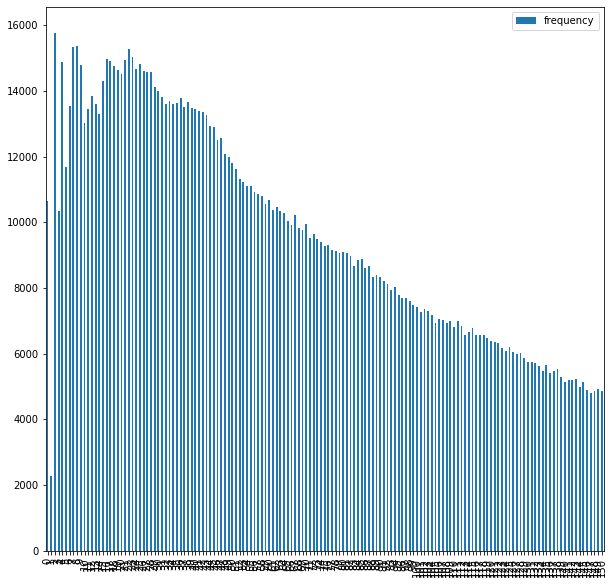

In [10]:
text_len_freq.plot.bar(figsize=(10,10))

### Finding the best cut off length

In [11]:
k_length = [ precent * 15 for precent in range(1,15)]
k_length.insert(0, 1)
k_length.insert(0, 0)
k_length

[0, 1, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 180, 195, 210]

In [12]:
# Basic model 
def get_cv_from_basic_model(train):
    # Simulate modeling
    vectorizer = TfidfVectorizer(use_idf=1,stop_words=stop_word)
    vectorizer.fit(sample_text['text'])
    X_tfidf = vectorizer.transform(sample_text['text'])
    
    le = preprocessing.LabelEncoder()
    author_encoded = le.fit_transform(sample_text['author'])

    X = X_tfidf
    Y = author_encoded

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, stratify=Y)

    model = MultinomialNB(alpha=0.1)
    model.fit(X_train, Y_train)
    predict = model.predict_proba(X_test)

    cv = np.mean(cross_val_score(model, X_train, Y_train, cv=10))
    return cv

In [13]:
cv_history = []
for length in k_length:
    
    sample_text = pd.DataFrame(train)
    
    indexNames = []
    for key in sample_text['text'].keys():
        if len(sample_text['text'][key]) <= length:
            indexNames.append(key)
    sample_text.drop(indexNames , inplace=True)
    
    cv = get_cv_from_basic_model(sample_text)
    
    print('length:' , length)
    print("cv: ", cv)
    cv_history.append(cv)


length: 0
cv:  0.5906639685760922
length: 1
cv:  0.5914405242269138
length: 15
cv:  0.600927091027122
length: 30
cv:  0.6244520743341886
length: 45
cv:  0.6470335865626159
length: 60
cv:  0.6664380663062842
length: 75
cv:  0.6837356412855159
length: 90
cv:  0.6976617471724738
length: 105
cv:  0.7103932894276326
length: 120
cv:  0.7200708881894101
length: 135
cv:  0.7294377843736075
length: 150
cv:  0.735321526374048
length: 165
cv:  0.7414059009318228
length: 180
cv:  0.7444536543688357
length: 195
cv:  0.7479935889300611
length: 210
cv:  0.7495689800819647


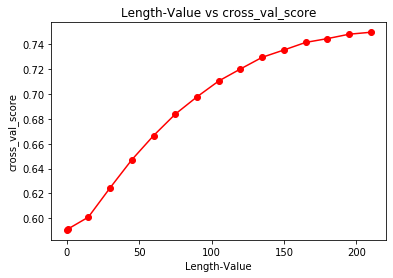

In [14]:
plt.title('Length-Value vs cross_val_score')
plt.plot(k_length, cv_history, marker='o', color='red');
plt.xlabel('Length-Value')
plt.ylabel('cross_val_score');
plt.show();

In [15]:
length = 150

# uncommented it for testing
# length = testing_length

# Drop outlines
print("Data size before removing outlines: ", len(train))
indexNames = []
for key in train['text'].keys():
    if len(train['text'][key]) <= length:
        indexNames.append(key)
train.drop(indexNames , inplace=True)
print("Data size after removing outlines: ", len(train))

Data size before removing outlines:  1904848
Data size after removing outlines:  442861


### Sampling for author Pepys Samuel

In [16]:
Pepys_Samuel = train[ train['author'] == 'Pepys, Samuel' ]
Pepys_Samuel

,text,author
258891,CLERK OF THE ACTS AND SECRETARY TO THE ADMIRAL...,"Pepys, Samuel"
258896,Lay very long in bed discoursing with Mr Hill ...,"Pepys, Samuel"
258897,At last up and it being a very foule day for r...,"Pepys, Samuel"
258898,However I dined well and after dinner all on s...,"Pepys, Samuel"
258899,But by and by Sir W Batten and I took coach an...,"Pepys, Samuel"
...,...,...
315023,Had the umbles of it for dinner Hates to have ...,"Pepys, Samuel"
315024,Hugged it being cold now in the mornings Hunt ...,"Pepys, Samuel"
315027,Stewards face Night the Dutch burned our ships...,"Pepys, Samuel"
315028,They want where to set their feet to begin to ...,"Pepys, Samuel"


In [17]:
Pepys_Samuel_text = []
Pepys_Samuel_text.append(" ".join(Pepys_Samuel['text']))
# Pepys_Samuel_text

In [18]:
cv = CountVectorizer(stop_words=stop_word)
 
# this steps generates word counts for the words in your docs
word_count_vector = cv.fit_transform(Pepys_Samuel_text)
word_count_vector

<1x20663 sparse matrix of type '<class 'numpy.int64'>'
	with 20663 stored elements in Compressed Sparse Row format>

In [19]:
# print Frequency values
df = pd.DataFrame(word_count_vector.T.todense(), index=cv.get_feature_names(), columns=["Frequency"])

# sort descending
df = df.sort_values(by=["Frequency"], ascending=False)
df = df[df['Frequency'] > 0]
df.head(10)

,Frequency
sir,7885
home,7632
mr,6392
lord,5956
great,5522
wife,5466
office,5072
come,4718
business,4703
good,4644


### Sampling of TF-IDF

In [20]:
vectorizer = TfidfVectorizer(use_idf=1,stop_words=stop_word)
vectorizer.fit(train['text'])
X_tfidf = vectorizer.transform(Pepys_Samuel_text)

In [21]:
X_tfidf

<1x204034 sparse matrix of type '<class 'numpy.float64'>'
	with 20663 stored elements in Compressed Sparse Row format>

In [22]:
X_tfidf_sample = X_tfidf
X_tfidf_sample = pd.DataFrame(X_tfidf_sample.T.todense(), index=vectorizer.get_feature_names(), columns=['TF-IDF'])

# Sort TF-IDF by descending
X_tfidf_sample = X_tfidf_sample.sort_values(by=["TF-IDF"],ascending=False)

# Drop TF-IDF value less than 0
X_tfidf_sample = X_tfidf_sample[X_tfidf_sample['TF-IDF'] > 0]
X_tfidf_sample

,TF-IDF
sir,0.239361
home,0.229838
lord,0.191707
office,0.178870
wife,0.173776
...,...
exclaimed,0.000046
stream,0.000044
caught,0.000041
im,0.000040


In [23]:
X_tfidf = vectorizer.transform(train['text'])

le = preprocessing.LabelEncoder()
author_encoded = le.fit_transform(train['author'])
len(le.classes_)

20

## Dimensionality reduction

### Feature Selection based on F-Score

In [24]:
k_value = [int(X_tfidf.shape[1] * 0.05 * k) for k in range(1, 20)]
k_value

[10201,
 20403,
 30605,
 40806,
 51008,
 61210,
 71411,
 81613,
 91815,
 102017,
 112218,
 122420,
 132622,
 142823,
 153025,
 163227,
 173428,
 183630,
 193832]

### Finding the best K value

In [25]:
cv_history = []
for k in k_value:
    
    k_feature = SelectKBest(f_classif, k=k)
    X_tfidf_final = k_feature.fit_transform(X_tfidf, author_encoded)

    X = X_tfidf_final
    Y = author_encoded

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, stratify=Y)

    model = MultinomialNB(alpha=0.1)
    model.fit(X_train, Y_train)
    predict = model.predict_proba(X_test)

    cv = np.mean(cross_val_score(model, X_train, Y_train, cv=10))
    
    print('k:' , k)
    print("cv: ", cv)
    cv_history.append(cv)


k: 10201
cv:  0.6540692482087913
k: 20403
cv:  0.7015636305690666
k: 30605
cv:  0.7220339857626348
k: 40806
cv:  0.7313873392239152
k: 51008
cv:  0.7373936944405954
k: 61210
cv:  0.7411873509448605
k: 71411
cv:  0.7423841379621076
k: 81613
cv:  0.7433601490928682
k: 91815
cv:  0.7447349764407377
k: 102017
cv:  0.7439097198885463
k: 112218
cv:  0.7435306936783606
k: 122420
cv:  0.7416638509948712
k: 132622
cv:  0.7400232203413758
k: 142823
cv:  0.7400783928738865
k: 153025
cv:  0.7391601013614373
k: 163227
cv:  0.7383246585757667
k: 173428
cv:  0.7368545309803416
k: 183630
cv:  0.7368469205655993
k: 193832
cv:  0.7357780841251189


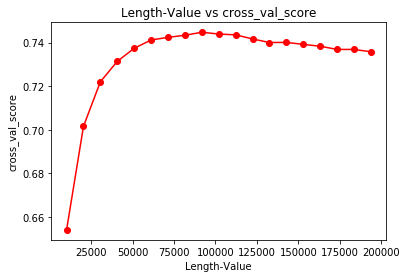

In [26]:
plt.title('Length-Value vs cross_val_score')
plt.plot(k_value, cv_history, marker='o', color='red');
plt.xlabel('Length-Value')
plt.ylabel('cross_val_score');
plt.show();

In [27]:
k_value = 105602

# uncommented it for testing
# k_value = testing_k

k_feature = SelectKBest(f_classif, k=k_value)
X_tfidf_final = k_feature.fit_transform(X_tfidf, author_encoded)


### Split training and testing Data

In [28]:
X = X_tfidf_final
Y = author_encoded

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, stratify=Y)


In [29]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(398574, 105602)
(44287, 105602)
(398574,)
(44287,)


### Basic Naive Bayes

In [30]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota


In [31]:
def evaluate(predictions, Y_test):
    log_loss = multiclass_logloss(Y_test, predictions)
    accuracy = accuracy_score(predictions.argmax(axis=1), Y_test)
    print("Logloss: %0.3f " % log_loss)
    print("Accuracy: %0.3f " % accuracy)
    
    return log_loss, accuracy

In [32]:
# Basic Naive Bayes Model
model = MultinomialNB()
model.fit(X_train, Y_train)
predict = model.predict_proba(X_test)


In [33]:
# Evaluate Basic Naive Bayes on TF-IDF
basic_Naive_Bayes_logloss, basic_Naive_Bayes_accuracy = evaluate(predict, Y_test)

Logloss: 1.470 
Accuracy: 0.659 


### Grid Search

In [34]:
k_feature = [int(X_tfidf.shape[1] * 5 * precent / 100) for precent in range(2,14)]
k_feature

[20403,
 30605,
 40806,
 51008,
 61210,
 71411,
 81613,
 91815,
 102017,
 112218,
 122420,
 132622]

In [35]:
# Reference: https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html

# Define a pipeline combining a text feature extractor with a simple
# classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('feature', SelectKBest()),
    ('clf', MultinomialNB()),
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
#     'tfidf__analyzer': ('word', 'char', 'char_wb'),
    'tfidf__use_idf': [True],
#     'tfidf__min_df': (1,2,3),
    'tfidf__smooth_idf': (True, False),
    'tfidf__stop_words': ['english'],
    'tfidf__sublinear_tf': (True, False),
    'feature__k': k_feature,
    'clf__alpha': [0.1],
}

# find the best parameters for both the feature extraction and the
# classifier
grid_search = GridSearchCV(pipeline, parameters, n_jobs=4, verbose=1)


X_train, X_test, Y_train, Y_test = train_test_split(train['text'], Y, test_size=0.1, stratify=Y)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(X_train, Y_train)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['tfidf', 'feature', 'clf']
parameters:
{'clf__alpha': [0.1],
 'feature__k': [20403,
                30605,
                40806,
                51008,
                61210,
                71411,
                81613,
                91815,
                102017,
                112218,
                122420,
                132622],
 'tfidf__smooth_idf': (True, False),
 'tfidf__stop_words': ['english'],
 'tfidf__sublinear_tf': (True, False),
 'tfidf__use_idf': [True]}
Fitting 3 folds for each of 48 candidates, totalling 144 fits


//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  5.1min
[Parallel(n_jobs=4)]: Done 144 out of 144 | elapsed: 18.3min finished


done in 1114.018s

Best score: 0.715
Best parameters set:
	clf__alpha: 0.1
	feature__k: 81613
	tfidf__smooth_idf: False
	tfidf__stop_words: 'english'
	tfidf__sublinear_tf: True
	tfidf__use_idf: True


In [36]:
grid_search.best_estimator_
Tfidf_best_estimator = grid_search.best_estimator_[0]
print("Tfidf_best_estimator: ", Tfidf_best_estimator)
SelectKBest_best_estimator = grid_search.best_estimator_[1]
print("SelectKBest_best_estimator: ", SelectKBest_best_estimator)
MultinomialNB_best_estimator = grid_search.best_estimator_[2]
print("MultinomialNB_best_estimator: ", MultinomialNB_best_estimator)

Tfidf_best_estimator:  TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=False, stop_words='english', strip_accents=None,
                sublinear_tf=True, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)
SelectKBest_best_estimator:  SelectKBest(k=81613, score_func=<function f_classif at 0x120e6e7b8>)
MultinomialNB_best_estimator:  MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)


### Naive Bayes after Grid Search

In [46]:
vectorizer = TfidfVectorizer(stop_words=stop_word, sublinear_tf=True, use_idf=True, smooth_idf=False)
# vectorizer = Tfidf_best_estimator

vectorizer.fit(train['text'])
X_tfidf = vectorizer.transform(train['text'])

In [47]:
k_feature = SelectKBest(f_classif, k=k_value)
# k_feature = SelectKBest_best_estimator

X_tfidf_final = k_feature.fit_transform(X_tfidf, author_encoded)

In [48]:
X = X_tfidf_final
Y = author_encoded

In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, stratify=Y)

In [50]:
model = MultinomialNB(alpha=0.1)
# model = MultinomialNB_best_estimator

model.fit(X_train, Y_train)
predict = model.predict_proba(X_test)

In [51]:
# Evaluate Basic Naive Bayes on TF-IDF
basic_Naive_Bayes_logloss, basic_Naive_Bayes_accuracy = evaluate(predict, Y_test)

Logloss: 1.061 
Accuracy: 0.751 


### Cross Validation

In [52]:
cv = np.mean(cross_val_score(model, X_train, Y_train, cv=10))
cv

0.7438141441399386